In [56]:
import pandas as pd
import numpy as np
import math 
import matplotlib.pyplot as plt
from graphviz import Digraph
import random
import seaborn as sns

In [2]:
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label= n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

 # Разбираемся с производной

In [3]:
## Расмотрим квадратичную функцию
def f(x):
    return 3*x**2 - 4*x + 5

In [9]:
f(1), f(2), f(3)

(4, 9, 20)

In [11]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [12]:
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

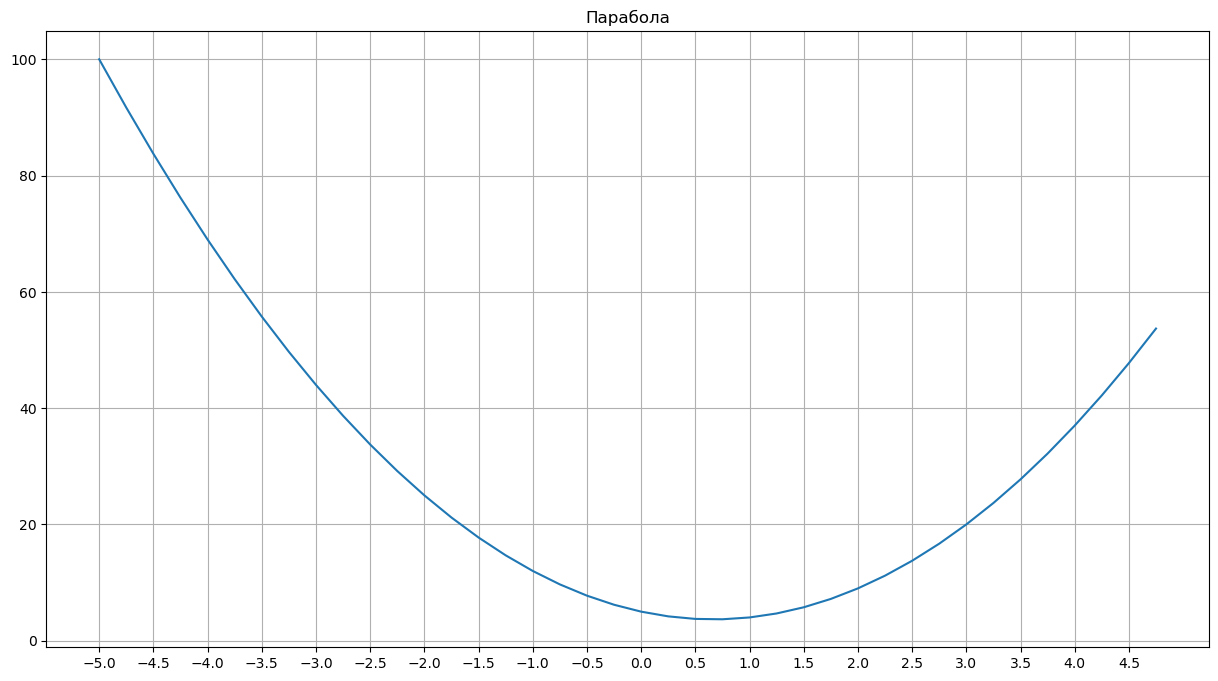

In [24]:
fig = plt.figure(figsize=(15, 8))
plt.plot(xs, ys)
plt.title('Парабола')
plt.grid()
plt.xticks(np.arange(-5, 5, 0.5));

* Где здесь производная? 
* Как её вычислить аналитически, определить по графику функции?

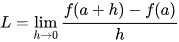

In [25]:
h = 0.0001
x = 3.0
f(x), f(x+h)

(20.0, 20.001400030000006)

In [28]:
(f(x+h) - f(x)) / h, 6*x - 4

(14.000300000063248, 14.0)

In [29]:
# в этой точке производная функции отрицательная 
h = 0.0001
x = -3.0
(f(x+h) - f(x)) / h

-21.999700000066014

In [31]:
# точка экстремума
h = 0.0000001
x = 2/3
(f(x+h) - f(x)) / h

2.9753977059954195e-07

In [32]:
# Более сложная функция 
a = 2.0
b = -3.0
c = 10
d = a*b + c
print(d)

4.0


In [35]:
# Рассмотрим частную производную по a
a = 2.0
b = -3.0
c = 10

d1 = a*b+c
a += h
d2 = a*b+c
print(d1, '|',  d2)
print('наклон', (d2-d1)/h)

4.0 | 3.9999997
наклон -2.9999999995311555


# Создаем класс value (аналог torch.Tensor для вектора с 0 размерностью)

## I

`Создаём класс который будет хранить числа и выполнять математические операции над ними`

In [60]:
class Value:
    def __init__(self, data):
        # Инициализируем число 
        self.data = data

    def __repr__(self):
        # Выводим значение при вызове объекта
        return f"Value(data={self.data})"

    def __add__(self, other):
        # операция сложения
        out = Value(self.data + other.data)
        return out

    def __mul__ (self, other):
        # операция умножения
        out = Value(self.data * other.data)
        return out

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
print('Переменная: ', a)
print('Сумма: ', a+b)
print('Произведение: ', a*b)
print('Значение выражения a*b+c: ', a*b+c)

Переменная:  Value(data=2.0)
Сумма:  Value(data=-1.0)
Произведение:  Value(data=-6.0)
Значение выражения a*b+c:  Value(data=4.0)


In [59]:
c = Value(10.0)
c

Value(data=10.0)

In [58]:
d

Value(data=10.0)

In [53]:
a = Value(2.0)

In [54]:
a

Value(data=2.0)

## II

`Добавляем возможность отслеживать вычислительный граф для переменных`

In [13]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        # Инициализируем число 
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        # Выводим значение при вызове объекта
        return f"Value(data={self.data})"

    def __add__(self, other):
        # операция сложения
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__ (self, other):
        # операция умножения
        out = Value(self.data * other.data, (self, other), '*')
        return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label = 'd'
print('Переменная: ', a)
print('Сумма: ', a+b)
print('Произведение: ', a*b)
print('Значение выражения a*b+c: ',d)

Переменная:  Value(data=2.0)
Сумма:  Value(data=-1.0)
Произведение:  Value(data=-6.0)
Значение выражения a*b+c:  Value(data=4.0)


In [14]:
d._prev, d._op

({Value(data=-6.0), Value(data=10.0)}, '+')

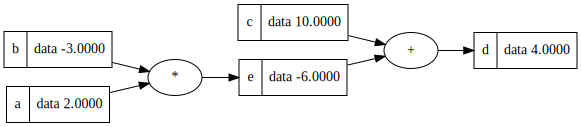

In [15]:
# Визуализруем вычислительный граф 
draw_dot(d)

# III

`Добавлеем функционал хранения частных производных - будет использоваться для вычисления градиентов при обратном распространении ошибки`

In [11]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        # Инициализируем число 
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
    
    def __repr__(self):
        # Выводим значение при вызове объекта
        return f"Value(data={self.data}, grad={self.grad})"

    def __add__(self, other):
        # операция сложения
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__ (self, other):
        # операция умножения
        out = Value(self.data * other.data, (self, other), '*')
        return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label = 'd'
f = Value(-2, label='f')
L = d * f
L.label = 'L'

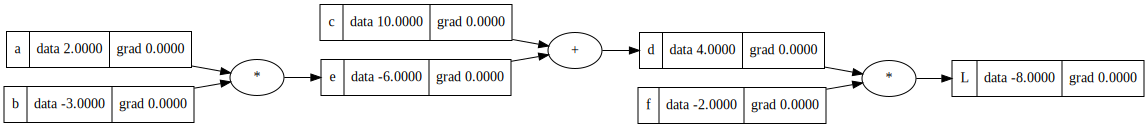

In [30]:
draw_dot(L)

# IV
`Сделаем обратное распространения ошибки в ручную чтобы понять как это работает` \
`Вычисляем частные производные в каждом узле графа по отношению к финальному результату`

In [22]:
# Используем функцую для численного вычисления производной для проверки
def my_func(local_var=None, h=0.00001):
    a = 2 + h if local_var == 'a' else 2
    b = -3 + h if local_var == 'b' else -3
    c = 10 + h if local_var == 'c' else 10
    e = a*b + h if local_var == 'e' else a*b
    d = e + c + h if local_var == 'd' else e + c
    f = -2 + h if local_var == 'f' else -2
    L = d*f + h if local_var == 'L' else d*f
    return L

def get_local_derivative(local_var, h=0.00001):
    return (my_func(local_var, h) - my_func(None, h)) / h

1) $\displaystyle \frac{dL}{dL} = 1$

   
2) $\displaystyle \frac{dL}{dd}: L = d * f => L'_d = f = -2$ 

   
3) $\displaystyle \frac{dL}{df}: L = d * f => L'_f = d = 4$


In [27]:
get_local_derivative('L'), get_local_derivative('d'), get_local_derivative('f')

(0.9999999999621422, -1.9999999999242843, 4.000000000026205)

In [12]:
L.grad = 1
d.grad = -2
f.grad = 4

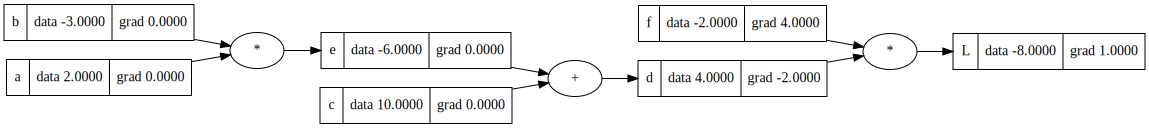

In [7]:
draw_dot(L)

4) $\displaystyle \frac{dL}{dc}$:  

   
    a) мы знаем как изменение параметра $d$ влияет на $L$ $(d.grad = -2)$  \
    б) мы знаем как изменение $c$ влиет на $d$: $\displaystyle d = c + e => \frac{dd}{dc} = 1$


Вспоминаем правило вычисления сложной функции: \
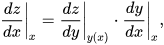 \
***Example*** \
$sin(2\cdot x)'_x$ = $sin(z)'_z \cdot (2 \cdot x)'_x $  ***where***  $(z = 2 \cdot x)$: \
$sin(z)'_z = cos(z)$ \
$2x'_x = 2$ \
$(sin(2x))'_x = cos(z)*2 = 2*(2x)$

**Тогда:** \
$\displaystyle \frac{dL}{dc}=(\frac{dL}{dd})*(\frac{dd}{dc}) = f * 1 = -2 $

**То же самое для `e`** \
$\displaystyle \frac{dL}{de}=(\frac{dL}{dd})*(\frac{dd}{de}) = f * 1 = -2 $

`Операция сложения позваляет градиенту протечь к следующей точке графа без изменений`

In [29]:
# проверка
get_local_derivative('c'), get_local_derivative('e')

(-1.9999999999242843, -1.9999999999242843)

In [13]:
c.grad = -2
e.grad = -2

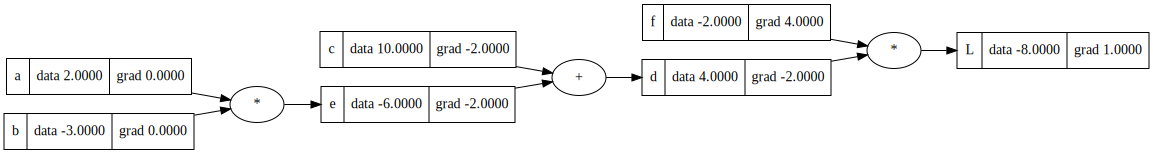

In [30]:
draw_dot(L)

**Продолжаем вычисления частных производных** \
$\displaystyle \frac{dL}{de} = -2.0$ 


$\displaystyle \frac{dL}{da} = \frac{dL}{de} * \frac{de}{da} = -2.0 * b = -2.0 * -3.0 = 6.0$ 


$\displaystyle \frac{dL}{db} = \frac{dL}{de} * \frac{de}{db} = -2.0 * a = -2.0 * 2.0 = -4.0$

In [31]:
# проверка
get_local_derivative('a'), get_local_derivative('b')

(6.000000000128124, -4.000000000026205)

In [32]:
a.grad = 6
b.grad = -4

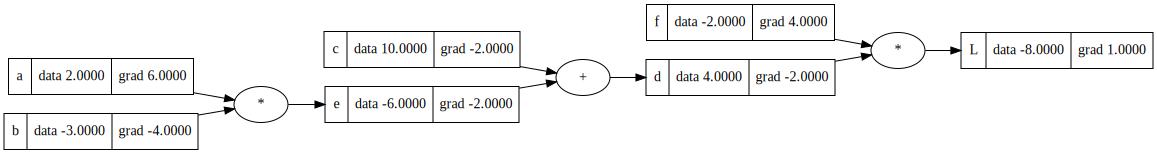

In [33]:
draw_dot(L)

# V
`Теперь мы знаем для каждой переменной как она влияет на конечный результат (направление и силу)` \
`Попробуем увеличить значение L слегка изменяя каждый элемент уравнения d в направлении градиента`

In [34]:
L

Value(data=-8.0, grad=1)

In [37]:
# forward pass

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a*b; e.label='e'
d = e + c; d.label = 'd'
L = d * f

L

Value(data=-6.586368000000001, grad=0.0)

**Сделаем всё то же самое для искусственного нейрона** \
`В качестве функции активации возьмем tanh`
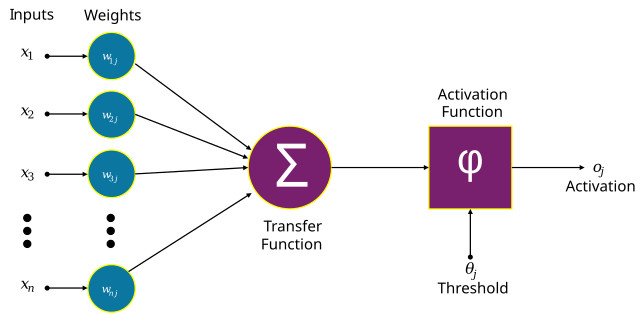

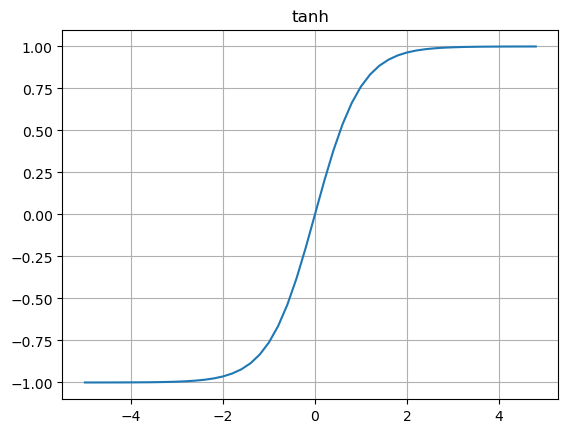

In [39]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()
plt.title('tanh')
plt.show()

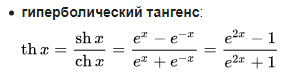

In [69]:
# Добавим в наш класс - вычисление гиперболического тангенса
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        # Инициализируем число 
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
    
    def __repr__(self):
        # Выводим значение при вызове объекта
        return f"Value(data={self.data}, grad={self.grad})"

    def __add__(self, other):
        # операция сложения
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__ (self, other):
        # операция умножения
        out = Value(self.data * other.data, (self, other), '*')
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        return out


In [78]:
# Входные парамметры 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Веса w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias 
b = Value(7, label='b')
# сумма произведений входных параметров на веса плюс баес 
x1w1 = x1*w1 
x1w1.label = 'x1w1'

x2w2 = x2*w2
x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b
n.label = 'n'

o = n.tanh()
o.label = 'o'

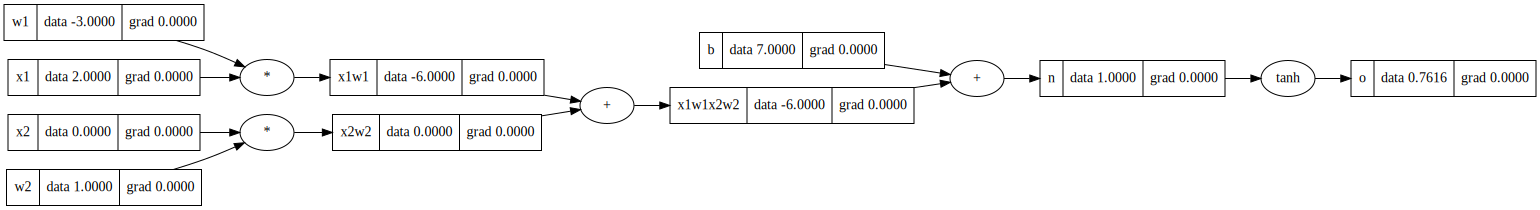

In [79]:
draw_dot(o)

**backpropagation again** \
$\displaystyle \frac{do}{do} = 1.0$ 

In [83]:
o.grad = 1

$\displaystyle o = tanh(n)$ \
$\displaystyle \frac{do}{dn} = 1 - tanh(n)^2 = 1 - o^2$ 

In [87]:
n.grad = 1 - o.data**2
n.grad

0.41997434161402614

In [88]:
# для операций сложения градиент протекает без измененийэ
b.grad = n.grad
x1w1x2w2.grad = n.grad

In [89]:
# то же самое 
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

In [90]:
# теперь для коэффициентов перемножения - всё также как мы делали до этого
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

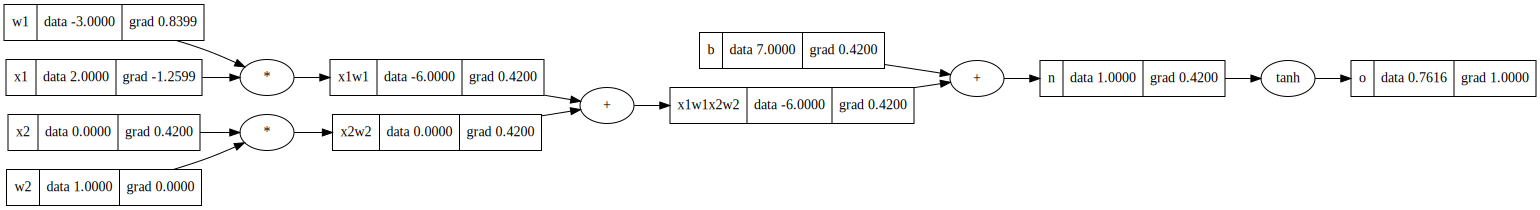

In [91]:
draw_dot(o)

# VI
`Автоматизируем backward propagation` \
`Добавим функцию которая будет для каждого элемента вычислять его частную производную` \

***`Идея в том что благодаря правилу дифференцирования сложной функции нам не нужно производить сложных рассчётов или хранить кучу информации - каждому параметру достаточно знать в какой математической операции он учавствует (чтобы вычислить его частную производную) и градиент впередиидущего параметра. Так наши параметры смогут по цепочке передавать свой градиент от выхода функции к её самым глуюбоким параметрам - это и называется методом обратного распространения ошибки или backpropagation`***

In [5]:
# По умолчанию функция backward ничего не делает
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        # Инициализируем число 
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None

    
    def __repr__(self):
        # Выводим значение при вызове объекта
        return f"Value(data={self.data}, grad={self.grad})"

    
    def __add__(self, other):
        # операция сложения
        out = Value(self.data + other.data, (self, other), '+')
        
        # для операции сложения градиент протекает без изменений
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        
        out._backward = _backward
            
        return out

    def __mul__ (self, other):
        # операция умножения
        out = Value(self.data * other.data, (self, other), '*')
        
        # Для умнлжения частная производная равна второму множителю
        def _bacward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad 
            
        out._backward = _bacward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        # вспоминаем производную гиперболического тангенса 
        def _backward():
            self.grad = (1 - t**2) * out.grad
            

        out._backward = _backward
        return out

In [33]:
# Запустим заново наше выражение

# Входные парамметры 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Веса w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias 
b = Value(7, label='b')
# сумма произведений входных параметров на веса плюс баес 
x1w1 = x1*w1 
x1w1.label = 'x1w1'

x2w2 = x2*w2
x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b
n.label = 'n'

o = n.tanh()
o.label = 'o'

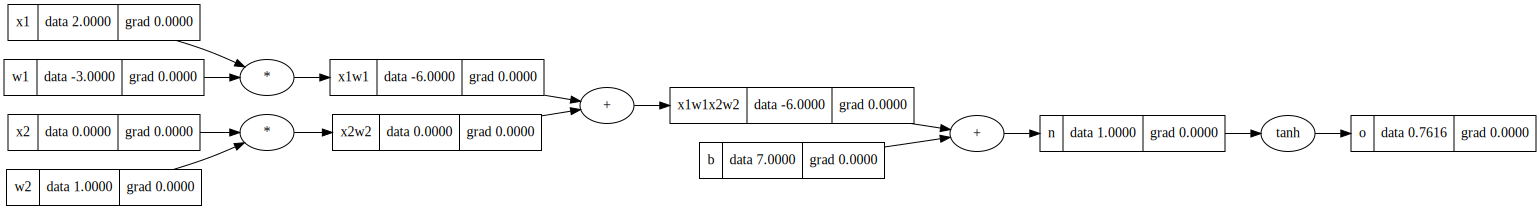

In [20]:
# После forward pass все производные равны нулю
draw_dot(o)

In [34]:
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

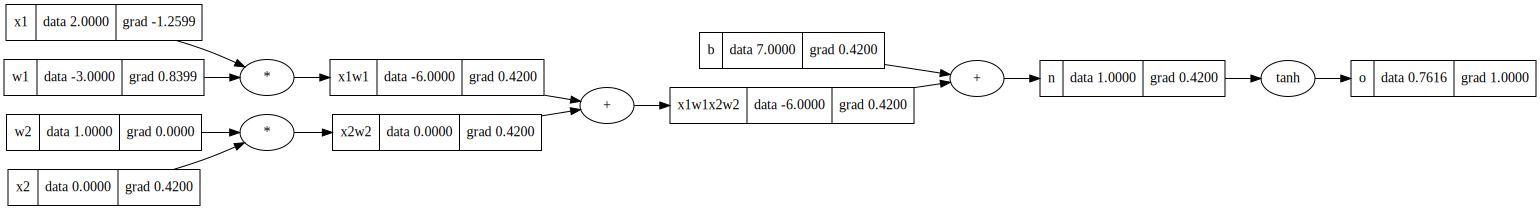

In [35]:
draw_dot(o)

In [23]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=7, grad=0.41997434161402614),
 Value(data=0.0, grad=0.41997434161402614),
 Value(data=1.0, grad=0.0),
 Value(data=0.0, grad=0.41997434161402614),
 Value(data=2.0, grad=-1.2599230248420783),
 Value(data=-3.0, grad=0.8399486832280523),
 Value(data=-6.0, grad=0.41997434161402614),
 Value(data=-6.0, grad=0.41997434161402614),
 Value(data=1.0, grad=0.41997434161402614),
 Value(data=0.7615941559557649, grad=1.0)]

In [38]:
# Forward pass

# Входные парамметры 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Веса w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias 
b = Value(7, label='b')
# сумма произведений входных параметров на веса плюс баес 
x1w1 = x1*w1 
x1w1.label = 'x1w1'

x2w2 = x2*w2
x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b
n.label = 'n'

o = n.tanh()
o.label = 'o'

# Bacward pass
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

o.grad = 1.0
for node in reversed(topo):
    node._backward()

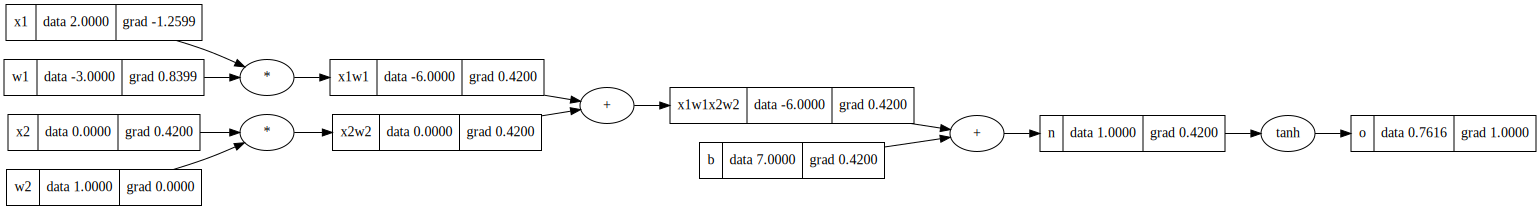

In [39]:
draw_dot(o)

In [40]:
#  Внесём этот функционал внутрь нашего класса
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        # Инициализируем число 
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None

    
    def __repr__(self):
        # Выводим значение при вызове объекта
        return f"Value(data={self.data}, grad={self.grad})"

    
    def __add__(self, other):
        # операция сложения
        out = Value(self.data + other.data, (self, other), '+')
        
        # для операции сложения градиент протекает без изменений
        def _backward():
            self.grad += 1.0 * out.grad  # Аккумулируем градиенты на случай если в графе параметр используется большего одного раза 
            other.grad += 1.0 * out.grad # 
        
        out._backward = _backward
            
        return out

    def __mul__ (self, other):
        # операция умножения
        out = Value(self.data * other.data, (self, other), '*')
        
        # Для умнлжения частная производная равна второму множителю
        def _bacward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad 
            
        out._backward = _bacward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        # вспоминаем производную гиперболического тангенса 
        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
            




In [41]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Веса w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias 
b = Value(7, label='b')
# сумма произведений входных параметров на веса плюс баес 
x1w1 = x1*w1 
x1w1.label = 'x1w1'
x2w2 = x2*w2
x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b
n.label = 'n'
o = n.tanh()
o.label = 'o'

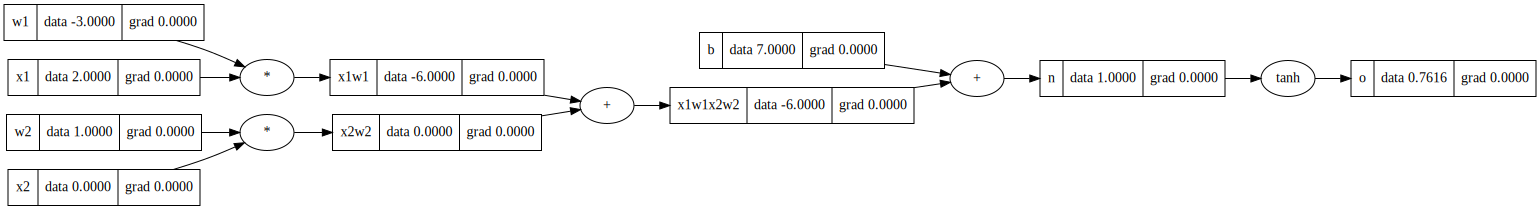

In [42]:
draw_dot(o)

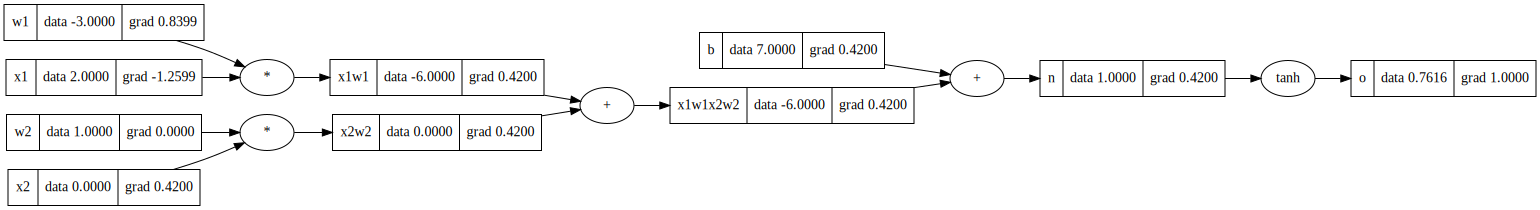

In [43]:
o.backward()
draw_dot(o)

# VII
**Добавим юзабилити**

1) `Добавим математические операции: вычитание, деление, возведение в степень, экспоненцирование`
2) `Добавим возможность проведения математических операций с числам, принудительно конвертируя их в Value класс`
3) ``
4) ``

In [47]:
a = Value(-2)
b = Value(3)

In [6]:
#  Внесём этот функционал внутрь нашего класса
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        # Инициализируем число 
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None

    # Выводим значение при вызове объекта
    def __repr__(self):
        return f"Value(data={self.data})"

    # операция сложения
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # на случай если прибавляем число (не класс Value)
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        # для операции сложения градиент протекает без изменений
        def _backward():
            self.grad += 1.0 * out.grad  # Аккумулируем градиенты на случай если в графе параметр используется большего одного раза 
            other.grad += 1.0 * out.grad # 
        
        out._backward = _backward
            
        return out
        
    # операция умножения
    def __mul__ (self, other):
        other = other if isinstance(other, Value) else Value(other) # на случай если умножаем на число (не класс Value)
        out = Value(self.data * other.data, (self, other), '*')
        
        # Для умнлжения частная производная равна второму множителю
        def _bacward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad 
            
        out._backward = _bacward
        return out

    # Возведение в степень 
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
    
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
    
        return out
        
    # Если умножаем число на Value меняем их места чтобы избежать ошибки
    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __radd__(self, other): # other + self
        return self + other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        # вспоминаем производную гиперболического тангенса 
        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    # экспоненцирование
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
          self.grad += out.data * out.grad # Производная exp(x) = exp(x)
        out._backward = _backward
    
        return out

    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

# VIII
`Строим нейронную сеть`

In [30]:
# 1 нейрон
class Neuron():
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

# Слой нейронов
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

# Простая полносвязная сеть
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [31]:
x = [2.0, 3.0, -1]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.7651341187162786)

In [32]:
n.parameters()

[Value(data=0.24674778218614013),
 Value(data=-0.48232116731515995),
 Value(data=0.5878371624395959),
 Value(data=-0.6577531476526486),
 Value(data=-0.167030151953379),
 Value(data=0.0737097863201408),
 Value(data=0.1516156953937866),
 Value(data=0.33423654221250176),
 Value(data=-0.24812906758990616),
 Value(data=-0.8754748563276236),
 Value(data=0.14467420796165098),
 Value(data=-0.8797119141197325),
 Value(data=-0.7663544662276058),
 Value(data=0.9244408840082528),
 Value(data=0.18538788842743714),
 Value(data=-0.586072379843299),
 Value(data=-0.9229571719299048),
 Value(data=-0.46048172943857946),
 Value(data=-0.25129596079721406),
 Value(data=-0.5301509105015187),
 Value(data=0.21534592579618983),
 Value(data=-0.07560116870308486),
 Value(data=-0.5472573142513995),
 Value(data=-0.38370664884629857),
 Value(data=-0.9934684999355519),
 Value(data=0.2391877464296015),
 Value(data=-0.03137275143076268),
 Value(data=0.3704267460586037),
 Value(data=-0.31790585061000565),
 Value(data=0.

In [39]:
len(n.parameters())

41

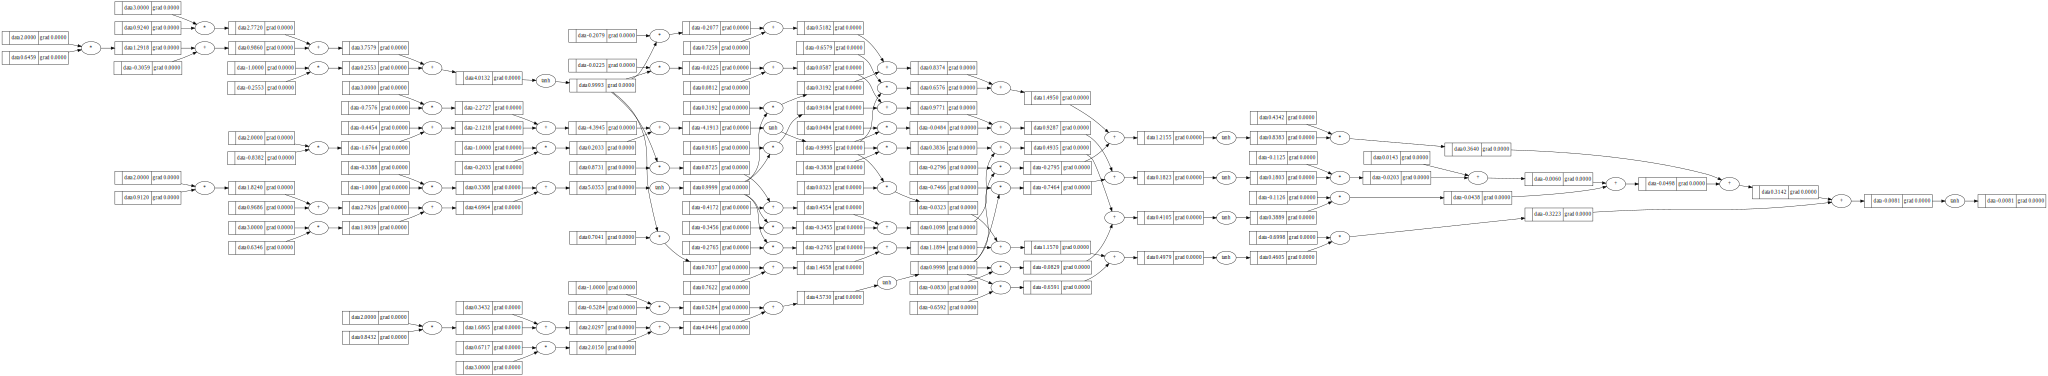

In [41]:
draw_dot(n(x))

# IX
`Функция потерь` \
`Обучение нейронной сети`

In [33]:
# sample dataset with targets
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

In [34]:
ypred = [n(x) for x in xs]

In [35]:
ypred

[Value(data=-0.7651341187162786),
 Value(data=-0.2883290184209729),
 Value(data=-0.6512412486982272),
 Value(data=-0.5024258522130415)]

In [36]:
loss = sum([(yout - ytrue)**2 for ytrue, yout in zip (ys, ypred)]) 
loss

Value(data=6.001090151085606)

In [37]:
loss.backward()

In [41]:
n.layers[0].neurons[0].w[0]

Value(data=0.24674778218614013)

In [38]:
n.layers[0].neurons[0].w[0].grad

0.9123816237789326

In [42]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [43]:
n.layers[0].neurons[0].w[0]

Value(data=0.2376239659483508)

In [44]:
ypred = [n(x) for x in xs]

In [45]:
# предсказания после 1 оптимизационного шага
ypred

[Value(data=-0.6727997647829993),
 Value(data=-0.28862591048065445),
 Value(data=-0.5901457570108599),
 Value(data=-0.43325510506850795)]

In [46]:
# loss
sum([(yout - ytrue)**2 for ytrue, yout in zip (ys, ypred)])

Value(data=5.526512844998677)

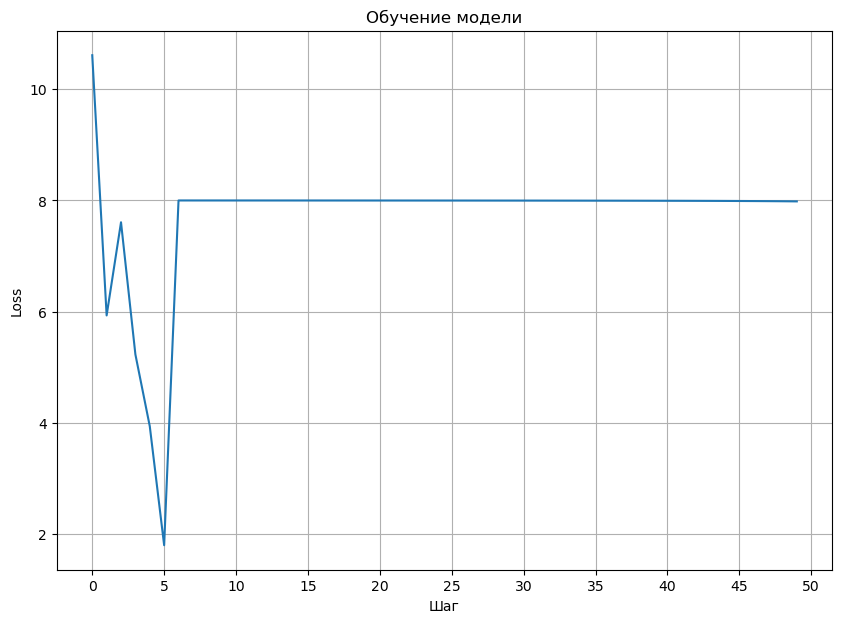

In [122]:
# Как выглядит взрыв градиента при слишком большом learning rate
n = MLP(3, [4, 4, 1])
losses = []
step = 50
lr = 0.4
for i in range(step):
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ytrue)**2 for ytrue, yout in zip (ys, ypred)]) 
    losses.append(loss.data)
    for p in n.parameters(): # zero gradients on every opt step!!!
        p.grad = 0.0
    loss.backward()
    for p in n.parameters():
        p.data += -lr * p.grad

fig = plt.figure(figsize=(10, 7))
sns.lineplot(x=list(range(step)), y=losses)
plt.title('Обучение модели')
plt.xlabel('Шаг')
plt.ylabel('Loss')
plt.xticks(np.arange(0, 51, 5))
plt.grid()
plt.show()

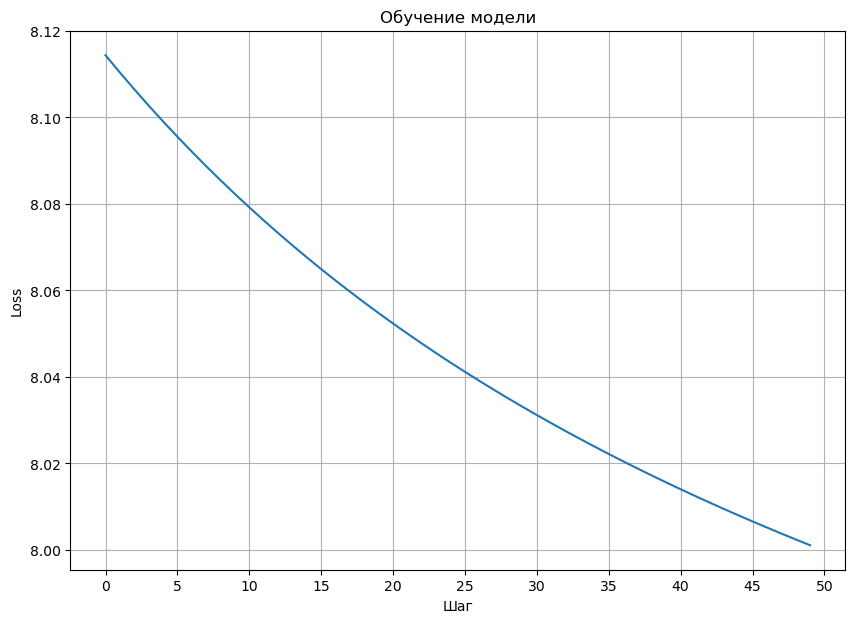

In [124]:
# слижком низкий lr
n = MLP(3, [4, 4, 1])
losses = []
step = 50
lr = 0.001
for i in range(step):
    ypred = [n(x) for x in xs] # forward pass
    loss = sum([(yout - ytrue)**2 for ytrue, yout in zip (ys, ypred)]) # calculate the loss
    losses.append(loss.data) 
    for p in n.parameters(): # zero gradients on every opt step!!! optimizer.zero_grad() in pytorch
        p.grad = 0.0
    loss.backward() # loss backward
    for p in n.parameters(): # optimizer step
        p.data += -lr * p.grad

fig = plt.figure(figsize=(10, 7))
sns.lineplot(x=list(range(step)), y=losses)
plt.title('Обучение модели')
plt.xlabel('Шаг')
plt.ylabel('Loss')
plt.xticks(np.arange(0, 51, 5))
plt.grid()
plt.show()

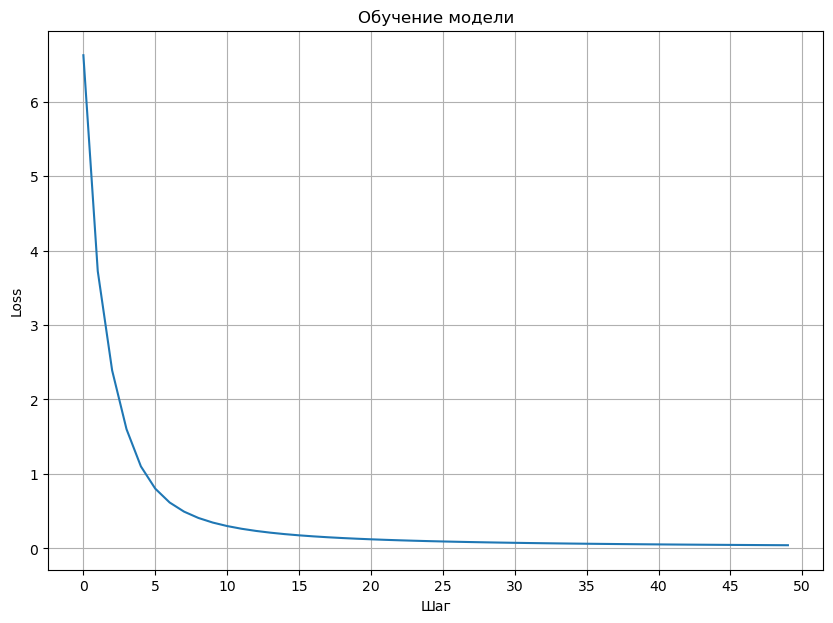

In [126]:
n = MLP(3, [4, 4, 1])
losses = []
step = 50
lr = 0.03
for i in range(step):
    ypred = [n(x) for x in xs] # forward pass
    loss = sum([(yout - ytrue)**2 for ytrue, yout in zip (ys, ypred)]) # calculate the loss
    losses.append(loss.data) 
    for p in n.parameters(): # zero gradients on every opt step!!! optimizer.zero_grad() in pytorch
        p.grad = 0.0
    loss.backward() # loss backward
    for p in n.parameters(): # optimizer step
        p.data += -lr * p.grad

fig = plt.figure(figsize=(10, 7))
sns.lineplot(x=list(range(step)), y=losses)
plt.title('Обучение модели')
plt.xlabel('Шаг')
plt.ylabel('Loss')
plt.xticks(np.arange(0, 51, 5))
plt.grid()
plt.show()